# Polygenic Risk Score Analysis

**Subject**: Trent Leslie (NU-UMMI-7887)  
**Data Source**: Nucleus Genomics Whole Genome Sequencing  
**Analysis Date**: January 2026

## What is a Polygenic Risk Score?

A Polygenic Risk Score (PRS) combines the effects of thousands to millions of genetic variants to estimate genetic predisposition for a trait or disease. Unlike single-gene tests (like BRCA1/2 for breast cancer), PRS captures the cumulative effect of many common variants, each with small individual effects.

### How PRS Works
1. **GWAS Discovery**: Scientists identify variants associated with a trait in large studies
2. **Effect Sizes**: Each variant gets a weight (beta coefficient) based on its association
3. **Score Calculation**: Your PRS = Σ(effect_weight × dosage) across all variants
4. **Interpretation**: Compare your score to population distributions

### Important Caveats
- Raw scores are not directly interpretable without population normalization
- PRS captures genetic risk only - lifestyle, environment, and other factors matter
- Performance varies by ancestry (most scores developed in European populations)
- These scores are for research/educational purposes, not clinical diagnosis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Results directory
results_dir = Path('results')

## PGS Scores Analyzed

### LD-Aware Method Selection

**Critical for accuracy**: Polygenic scores should use methods that account for **linkage disequilibrium (LD)** - the correlation between nearby genetic variants. Without LD correction, correlated variants get double-counted, inflating scores.

| Method | LD Handling | Quality |
|--------|-------------|---------|
| **LDpred / LDpred2** | Bayesian with LD reference panel | ✅ Gold standard |
| **PRS-CS / PRS-CSx** | Bayesian continuous shrinkage | ✅ Excellent |
| **AnnoPred** | Bayesian + functional annotations (based on LDpred) | ✅ Excellent |
| **lassosum / SBayesR** | Penalized regression with LD | ✅ Good |
| P+T with clumping | Basic clumping | ⚠️ Basic |
| Genome-wide sig. only | Minimal handling | ⚠️ Basic |

### Selected Scores

| PGS ID | Trait | Method | Variants | LD Status |
|--------|-------|--------|----------|-----------|
| PGS002308 | Type 2 Diabetes | **PRS-CSx** | 1,259,754 | ✅ LD-aware |
| PGS004034 | Alzheimer's Disease | **LDpred2-auto** | 1,046,908 | ✅ LD-aware |
| PGS000027 | Body Mass Index | **LDpred** | 2,100,302 | ✅ LD-aware |
| PGS004237 | Coronary Artery Disease | **LDpred** | 1,146,511 | ✅ LD-aware |
| PGS005236 | Coronary Artery Disease | **AnnoPred** | 2,994,055 | ✅ LD-aware |
| PGS001355 | Coronary Artery Disease | **AnnoPred** | 2,994,055 | ✅ LD-aware |

**Note**: PGS000748 (AD, 3.4M variants) was replaced with PGS004034 (LDpred2-auto) for proper LD handling. See `results/PGS000748_AD.txt` for archived comparison.

**Note**: PGS005236 and PGS001355 are both AnnoPred-based CAD scores from related studies (2025 and 2021). AnnoPred is a Bayesian framework built on LDpred that incorporates 61 functional annotation categories for improved SNP weighting. Both scores share identical variant counts and parameters but differ in evaluation cohort size and publication date.

In [2]:
# Define PGS metadata
pgs_info = {
    'PGS002308_T2D': {
        'trait': 'Type 2 Diabetes',
        'abbreviation': 'T2D',
        'variants_expected': 1259754,
        'method': 'PRS-CSx',
        'ld_aware': True,
        'citation': 'Ge T et al., Genome Medicine (2022)',
        'color': '#e74c3c'  # Red
    },
    'PGS004034_AD_LDpred2': {
        'trait': 'Alzheimer\'s Disease',
        'abbreviation': 'AD',
        'variants_expected': 1046908,
        'method': 'LDpred2-auto',
        'ld_aware': True,
        'citation': 'Monti R et al., AJHG (2024)',
        'color': '#9b59b6'  # Purple
    },
    'PGS000027_BMI': {
        'trait': 'Body Mass Index',
        'abbreviation': 'BMI',
        'variants_expected': 2100302,
        'method': 'LDpred',
        'ld_aware': True,
        'citation': 'Khera AV et al., Cell (2019)',
        'color': '#3498db'  # Blue
    },
    'PGS004237_CAD': {
        'trait': 'Coronary Artery Disease',
        'abbreviation': 'CAD',
        'variants_expected': 1146511,
        'method': 'LDpred',
        'ld_aware': True,
        'citation': 'Manikpurage HD et al., Circ Genom Precis Med (2021)',
        'color': '#e67e22'  # Orange
    },
    'PGS005236_CAD_AnnoPred': {
        'trait': 'Coronary Artery Disease',
        'abbreviation': 'CAD',
        'variants_expected': 2994055,
        'method': 'AnnoPred',
        'ld_aware': True,
        'citation': 'Hu J et al., PLoS Comp Bio (2025)',
        'color': '#f39c12'  # Yellow-orange (distinct from existing CAD)
    },
    'PGS001355_CAD_AnnoPred_2021': {
        'trait': 'Coronary Artery Disease',
        'abbreviation': 'CAD',
        'variants_expected': 2994055,
        'method': 'AnnoPred',
        'ld_aware': True,
        'citation': 'Ye Y et al., Circ Genom Prec Med (2021)',
        'color': '#d35400'  # Dark orange
    }
}

In [3]:
# Load all results
results = {}

for pgs_id, info in pgs_info.items():
    file_path = results_dir / f"{pgs_id}.txt"
    if file_path.exists():
        df = pd.read_csv(file_path, sep='\t')
        results[pgs_id] = {
            'data': df,
            'total_score': df['contribution'].sum(),
            'n_variants': len(df),
            'n_vcf': (df['source'] == 'vcf').sum(),
            'n_ref_lookup': (df['source'] == 'ref_lookup').sum(),
            **info
        }
        print(f"✓ Loaded {pgs_id}: {len(df):,} variants, Score = {results[pgs_id]['total_score']:.4f}")
    else:
        print(f"✗ Missing individual file: {file_path}")

# Load AnnoPred CAD scores from pgsc_calc aggregated results
pgsc_calc_results = results_dir / 'pgsc_calc_cad_comparison' / 'aggregated_scores.txt.gz'
if pgsc_calc_results.exists():
    import gzip
    with gzip.open(pgsc_calc_results, 'rt') as f:
        pgsc_df = pd.read_csv(f, sep='\t')
    
    # Map pgsc_calc column names to our score IDs
    pgsc_score_map = {
        'PGS005236_hmPOS_GRCh38_SUM': 'PGS005236_CAD_AnnoPred',
        'PGS001355_hmPOS_GRCh38_SUM': 'PGS001355_CAD_AnnoPred_2021'
    }
    
    for col, pgs_id in pgsc_score_map.items():
        if col in pgsc_df.columns and pgs_id in pgs_info:
            raw_score = pgsc_df[col].iloc[0]
            results[pgs_id] = {
                'total_score': raw_score,
                'n_variants': None,  # Not available from aggregated results
                'n_vcf': None,
                'n_ref_lookup': None,
                'data': None,  # Variant-level data not available
                **pgs_info[pgs_id]
            }
            print(f"✓ Loaded {pgs_id} from pgsc_calc: Score = {raw_score:.6f}")
else:
    print(f"⚠️ pgsc_calc results not found at {pgsc_calc_results}")
    print("  Run pgsc_calc with all 6 scores to include AnnoPred CAD comparisons")

print(f"\n📊 Total scores loaded: {len(results)}")


/tmp/ipykernel_3425464/3927223753.py:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep='\t')


✓ Loaded PGS002308_T2D: 1,259,279 variants, Score = 0.3920
✓ Loaded PGS004034_AD_LDpred2: 1,046,579 variants, Score = 1.6225


/tmp/ipykernel_3425464/3927223753.py:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep='\t')


✓ Loaded PGS000027_BMI: 2,099,995 variants, Score = 38.6380


/tmp/ipykernel_3425464/3927223753.py:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep='\t')


✓ Loaded PGS004237_CAD: 1,146,039 variants, Score = -0.2705
✗ Missing individual file: results/PGS005236_CAD_AnnoPred.txt
✗ Missing individual file: results/PGS001355_CAD_AnnoPred_2021.txt
✓ Loaded PGS005236_CAD_AnnoPred from pgsc_calc: Score = 0.316392
✓ Loaded PGS001355_CAD_AnnoPred_2021 from pgsc_calc: Score = 0.315542

📊 Total scores loaded: 6


## Summary Results

The table below shows the raw PRS values calculated from your genomic data.

In [4]:
# Create summary dataframe
summary_data = []
for pgs_id, r in results.items():
    # Handle scores from pgsc_calc that don't have variant-level data
    n_variants = r.get('n_variants')
    n_vcf = r.get('n_vcf')
    n_ref = r.get('n_ref_lookup')
    variants_expected = r.get('variants_expected', 1)
    
    summary_data.append({
        'Trait': r['trait'],
        'PGS ID': pgs_id.split('_')[0],
        'Method': r.get('method', 'Unknown'),
        'LD-Aware': '✅' if r.get('ld_aware', False) else '⚠️',
        'Raw Score': r['total_score'],
        'Variants Scored': n_variants if n_variants is not None else 'N/A',
        'From VCF': n_vcf if n_vcf is not None else 'N/A',
        'From Reference': n_ref if n_ref is not None else 'N/A',
        'Coverage (%)': (n_variants / variants_expected * 100) if n_variants is not None else 'N/A'
    })

summary_df = pd.DataFrame(summary_data)

# Use PGS ID as index for better display with multiple CAD scores
summary_df = summary_df.set_index('PGS ID')

# Display with formatting (handle N/A values)
def format_value(x, fmt):
    if x == 'N/A' or pd.isna(x):
        return 'N/A (pgsc_calc)'
    return fmt.format(x)

styled = summary_df.style.format({
    'Raw Score': '{:.4f}',
    'Variants Scored': lambda x: f'{x:,.0f}' if isinstance(x, (int, float)) else str(x),
    'From VCF': lambda x: f'{x:,.0f}' if isinstance(x, (int, float)) else str(x),
    'From Reference': lambda x: f'{x:,.0f}' if isinstance(x, (int, float)) else str(x),
    'Coverage (%)': lambda x: f'{x:.1f}%' if isinstance(x, (int, float)) else str(x)
})
styled


,Trait,Method,LD-Aware,Raw Score,Variants Scored,From VCF,From Reference,Coverage (%)
PGS ID,,,,,,,,
PGS002308,Type 2 Diabetes,PRS-CSx,✅,0.3920,"1,259,279",608559,650720,100.0%
PGS004034,Alzheimer's Disease,LDpred2-auto,✅,1.6225,"1,046,579",555676,490903,100.0%
PGS000027,Body Mass Index,LDpred,✅,38.6380,"2,099,995",1083253,1016742,100.0%
PGS004237,Coronary Artery Disease,LDpred,✅,-0.2705,"1,146,039",600733,545306,100.0%
PGS005236,Coronary Artery Disease,AnnoPred,✅,0.3164,N/A,N/A,N/A,N/A
PGS001355,Coronary Artery Disease,AnnoPred,✅,0.3155,N/A,N/A,N/A,N/A


## Visualization: Variant Source Distribution

This shows how many variants were found directly in your VCF vs inferred from the reference genome.

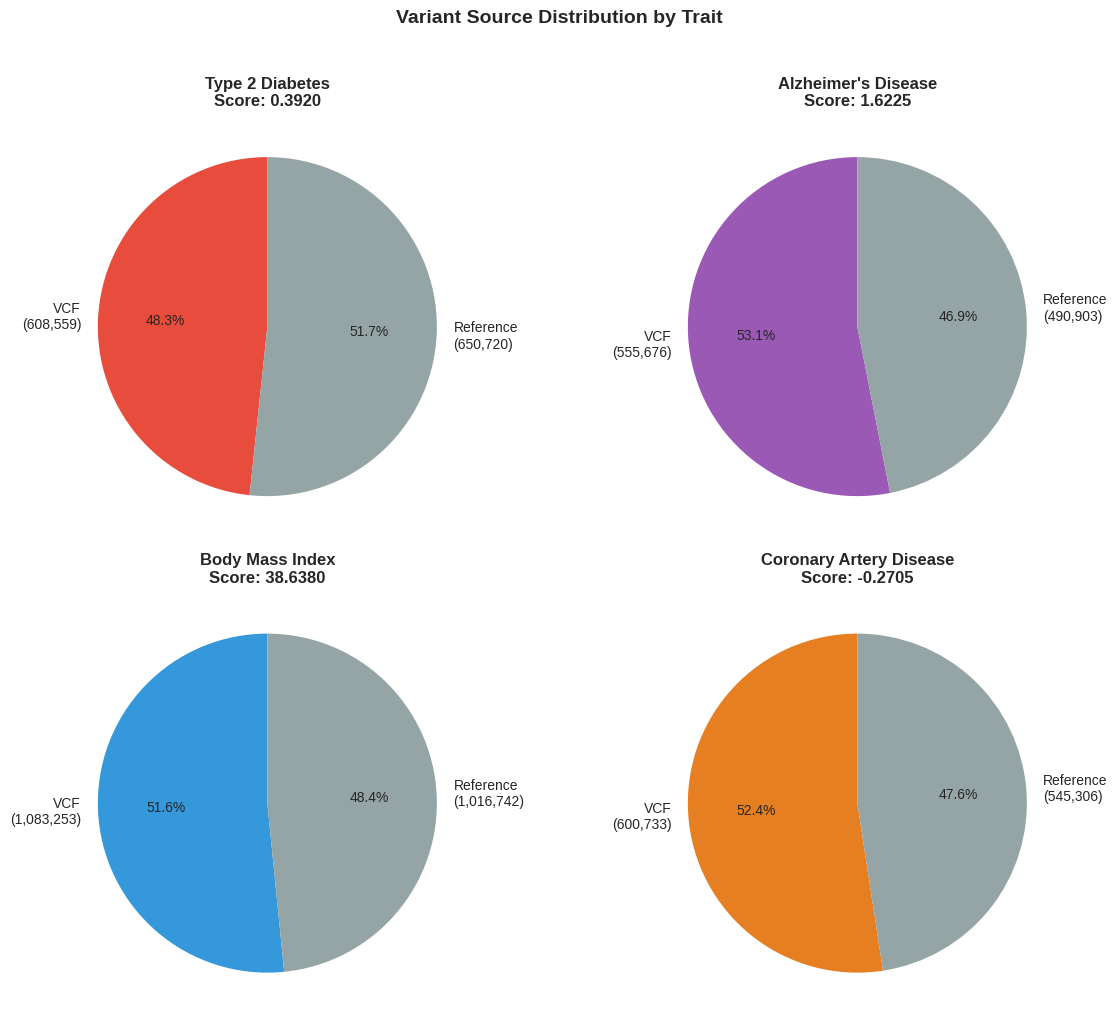


📝 Note: 2 scores loaded from pgsc_calc aggregated results
   (variant-level detail not available for these scores):
   - PGS005236_CAD_AnnoPred
   - PGS001355_CAD_AnnoPred_2021


In [5]:
# Filter to scores with variant-level data
scores_with_variants = {k: v for k, v in results.items() if v.get('data') is not None}
n_scores = len(scores_with_variants)

if n_scores == 0:
    print("No scores with variant-level data to display")
else:
    # Dynamic grid: 2 columns, variable rows
    n_cols = 2
    n_rows = (n_scores + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
    axes = axes.flatten() if n_scores > 1 else [axes]
    
    for idx, (pgs_id, r) in enumerate(scores_with_variants.items()):
        ax = axes[idx]
        
        # Pie chart of variant sources
        sizes = [r['n_vcf'], r['n_ref_lookup']]
        labels = [f"VCF\n({r['n_vcf']:,})", f"Reference\n({r['n_ref_lookup']:,})"]
        colors = [r['color'], '#95a5a6']
        
        ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
               startangle=90, textprops={'fontsize': 10})
        ax.set_title(f"{r['trait']}\nScore: {r['total_score']:.4f}", fontsize=12, fontweight='bold')
    
    # Hide unused subplots
    for idx in range(n_scores, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Variant Source Distribution by Trait', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('results/variant_sources.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Note about AnnoPred scores
    scores_without_variants = [k for k, v in results.items() if v.get('data') is None]
    if scores_without_variants:
        print(f"\n📝 Note: {len(scores_without_variants)} scores loaded from pgsc_calc aggregated results")
        print("   (variant-level detail not available for these scores):")
        for pgs_id in scores_without_variants:
            print(f"   - {pgs_id}")


## Contribution Distribution Analysis

Understanding how individual variants contribute to the total score.

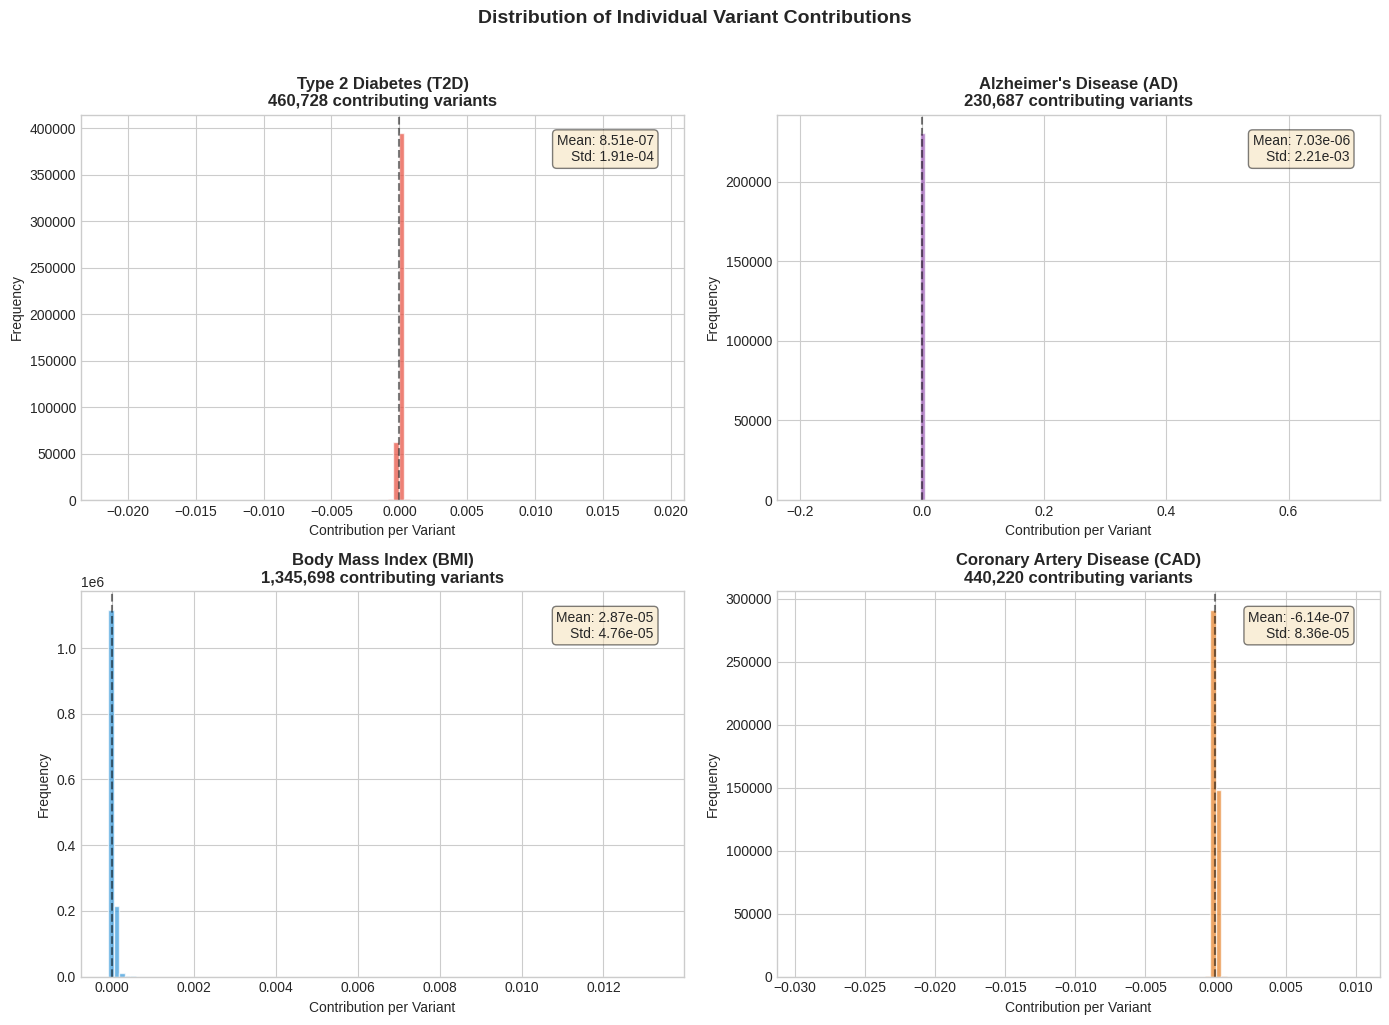

In [6]:
# Filter to scores with variant-level data
scores_with_variants = {k: v for k, v in results.items() if v.get('data') is not None}
n_scores = len(scores_with_variants)

if n_scores == 0:
    print("No scores with variant-level data to display")
else:
    # Dynamic grid: 2 columns, variable rows
    n_cols = 2
    n_rows = (n_scores + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))
    axes = axes.flatten() if n_scores > 1 else [axes]
    
    for idx, (pgs_id, r) in enumerate(scores_with_variants.items()):
        ax = axes[idx]
        df = r['data']
        
        # Filter to non-zero contributions for cleaner histogram
        nonzero = df[df['contribution'] != 0]['contribution']
        
        ax.hist(nonzero, bins=100, color=r['color'], alpha=0.7, edgecolor='white')
        ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
        ax.set_xlabel('Contribution per Variant')
        ax.set_ylabel('Frequency')
        ax.set_title(f"{r['trait']} ({r['abbreviation']})\n{len(nonzero):,} contributing variants", fontweight='bold')
        
        # Add statistics
        stats_text = f"Mean: {nonzero.mean():.2e}\nStd: {nonzero.std():.2e}"
        ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, 
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Hide unused subplots
    for idx in range(n_scores, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Distribution of Individual Variant Contributions', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('results/contribution_distributions.png', dpi=150, bbox_inches='tight')
    plt.show()


## Top Contributing Variants

Identifying the variants with largest positive and negative effects.

In [7]:
def show_top_variants(pgs_id, n=10):
    """Display top positive and negative contributing variants."""
    r = results[pgs_id]
    df = r['data'].copy()
    
    # Sort by absolute contribution
    df['abs_contribution'] = df['contribution'].abs()
    
    print(f"\n{'='*60}")
    print(f"{r['trait']} ({pgs_id.split('_')[0]})")
    print(f"Total Score: {r['total_score']:.4f}")
    print(f"{'='*60}")
    
    # Top positive
    print(f"\n📈 Top {n} POSITIVE contributions:")
    top_pos = df.nlargest(n, 'contribution')[['chr', 'pos', 'rsID', 'genotype', 'weight', 'contribution']]
    print(top_pos.to_string(index=False))
    
    # Top negative
    print(f"\n📉 Top {n} NEGATIVE contributions:")
    top_neg = df.nsmallest(n, 'contribution')[['chr', 'pos', 'rsID', 'genotype', 'weight', 'contribution']]
    print(top_neg.to_string(index=False))

# Show for T2D as most relevant to health profile
show_top_variants('PGS002308_T2D')


Type 2 Diabetes (PGS002308)
Total Score: 0.3920

📈 Top 10 POSITIVE contributions:
chr       pos       rsID genotype   weight  contribution
 17  37739849 rs11651755      C/C 0.009462      0.018924
 17  37743574 rs11263763      G/G 0.009421      0.018842
  5  56503357   rs157843      A/A 0.008868      0.017735
  1 213985913   rs340874      C/C 0.008749      0.017498
 10  92704550 rs12778642      G/G 0.008569      0.017137
  1  39562508  rs4660293      G/G 0.007063      0.014126
  5  56520254   rs458036      C/C 0.006884      0.013768
 14  32834068  rs7146265      A/A 0.005719      0.011438
  6  32717773  rs3916765      G/A 0.011417      0.011417
 11   2825839   rs163184      T/G 0.010742      0.010742

📉 Top 10 NEGATIVE contributions:
chr       pos       rsID genotype    weight  contribution
  9  81694033  rs2796441      A/A -0.010705     -0.021411
  1 229537208   rs348330      A/A -0.010554     -0.021108
 10 113006958  rs7896811      C/T -0.020639     -0.020639
 11   2818521  rs2237892

In [8]:
# Show for other traits
show_top_variants('PGS004034_AD_LDpred2')
show_top_variants('PGS004237_CAD')


Alzheimer's Disease (PGS004034)
Total Score: 1.6225

📈 Top 10 POSITIVE contributions:
 chr       pos       rsID genotype   weight  contribution
  19  44892009   rs157580      G/A 0.704851      0.704851
  19  44901434   rs405697      G/G 0.301558      0.603116
  11  86157598  rs3851179      C/C 0.072855      0.145710
   7 143410495 rs12703526      T/T 0.063488      0.126976
  19  44913221   rs584007      A/G 0.122880      0.122880
  19  44911194   rs439401      T/C 0.107153      0.107153
  16  81739604 rs12444183      G/G 0.051330      0.102661
   2 127137039   rs744373      A/G 0.094454      0.094454
   6  41082156  rs6918969      T/C 0.093356      0.093356
  17  63483402     rs4311      C/C 0.046447      0.092894

📉 Top 10 NEGATIVE contributions:


 chr       pos       rsID genotype    weight  contribution
  19   1039445  rs3795065      T/T -0.096547     -0.193094
  19  44864520  rs8105340      T/T -0.070320     -0.140639
   2  65381229   rs268134      G/G -0.052116     -0.104231
  19  44857967   rs440277      G/A -0.090843     -0.090843
  11  60309220 rs11824734      A/A -0.032267     -0.064534
   6  47464901  rs9381563      C/T -0.055699     -0.055699
  19  44738850  rs2927438      G/G -0.027422     -0.054844
  11  71967340  rs7925411      T/T -0.027232     -0.054464
   1 207611623  rs3818361      A/G -0.053967     -0.053967
  21  26784537  rs2830500      C/A -0.045814     -0.045814

Coronary Artery Disease (PGS004237)
Total Score: -0.2705

📈 Top 10 POSITIVE contributions:
chr       pos       rsID genotype   weight  contribution
  9  22125914  rs1333050      C/T 0.009789      0.009789
  1  56499992  rs9970807      C/T 0.008688      0.008688
  7 130023656 rs11556924      C/T 0.007684      0.007684
  6 160687504  rs6935921      C

## CAD Score Concordance Analysis

Three different CAD polygenic risk scores are included in this analysis to validate concordance:

| PGS ID | Method | Variants | Publication |
|--------|--------|----------|-------------|
| PGS004237 | LDpred | 1.1M | Manikpurage et al., 2021 |
| PGS005236 | AnnoPred | 3.0M | Hu et al., 2025 |
| PGS001355 | AnnoPred | 3.0M | Ye et al., 2021 |

**Expected Concordance**: PGS005236 and PGS001355 use the identical AnnoPred model with the same variant weights - they should produce essentially identical raw scores (~0.3% difference expected due to minor variant matching differences). PGS004237 uses a different method (LDpred) with different variants, so raw scores will differ but risk stratification should be consistent.

In [9]:
# CAD Score Concordance Analysis
cad_scores = {k: v for k, v in results.items() if 'CAD' in k}

if len(cad_scores) >= 2:
    print("=" * 70)
    print("CORONARY ARTERY DISEASE SCORE CONCORDANCE ANALYSIS")
    print("=" * 70)
    
    print("\n### Raw Score Comparison ###")
    print(f"{'Score ID':<35} {'Method':<15} {'Raw Score':>12}")
    print("-" * 65)
    for pgs_id, r in cad_scores.items():
        print(f"{pgs_id:<35} {r['method']:<15} {r['total_score']:>12.6f}")
    
    # Calculate concordance between AnnoPred scores
    annopred_2025 = results.get('PGS005236_CAD_AnnoPred', {}).get('total_score')
    annopred_2021 = results.get('PGS001355_CAD_AnnoPred_2021', {}).get('total_score')
    ldpred_cad = results.get('PGS004237_CAD', {}).get('total_score')
    
    if annopred_2025 is not None and annopred_2021 is not None:
        diff = abs(annopred_2025 - annopred_2021)
        pct_diff = (diff / abs(annopred_2025)) * 100 if annopred_2025 != 0 else 0
        
        print(f"\n### AnnoPred Concordance (PGS005236 vs PGS001355) ###")
        print(f"PGS005236 (AnnoPred 2025): {annopred_2025:.6f}")
        print(f"PGS001355 (AnnoPred 2021): {annopred_2021:.6f}")
        print(f"Absolute difference:        {diff:.6f}")
        print(f"Percent difference:         {pct_diff:.2f}%")
        
        if pct_diff < 1.0:
            print("✅ Excellent concordance - scores are essentially identical as expected")
        elif pct_diff < 5.0:
            print("✓ Good concordance - minor differences due to variant matching")
        else:
            print("⚠️ Unexpected divergence - investigate variant matching differences")
    
    # Compare LDpred vs AnnoPred direction
    if ldpred_cad is not None and annopred_2025 is not None:
        print(f"\n### Method Comparison (LDpred vs AnnoPred) ###")
        print(f"PGS004237 (LDpred):        {ldpred_cad:.6f}")
        print(f"PGS005236 (AnnoPred):      {annopred_2025:.6f}")
        
        # Check sign agreement (both positive or both negative)
        same_direction = (ldpred_cad >= 0) == (annopred_2025 >= 0)
        print(f"\nRisk direction agreement: {'✅ Yes' if same_direction else '⚠️ No'}")
        
        if not same_direction:
            print("Note: Different methods can produce scores with different signs")
            print("      due to centering choices. Risk stratification (percentiles)")
            print("      should still be consistent when normalized against population.")
else:
    print("⚠️ Less than 2 CAD scores loaded - concordance analysis requires multiple scores")
    print(f"   CAD scores found: {list(cad_scores.keys())}")


CORONARY ARTERY DISEASE SCORE CONCORDANCE ANALYSIS

### Raw Score Comparison ###
Score ID                            Method             Raw Score
-----------------------------------------------------------------
PGS004237_CAD                       LDpred             -0.270483
PGS005236_CAD_AnnoPred              AnnoPred            0.316392
PGS001355_CAD_AnnoPred_2021         AnnoPred            0.315542

### AnnoPred Concordance (PGS005236 vs PGS001355) ###
PGS005236 (AnnoPred 2025): 0.316392
PGS001355 (AnnoPred 2021): 0.315542
Absolute difference:        0.000850
Percent difference:         0.27%
✅ Excellent concordance - scores are essentially identical as expected

### Method Comparison (LDpred vs AnnoPred) ###
PGS004237 (LDpred):        -0.270483
PGS005236 (AnnoPred):      0.316392

Risk direction agreement: ⚠️ No
Note: Different methods can produce scores with different signs
      due to centering choices. Risk stratification (percentiles)
      should still be consistent when no

## Integration with Known Single-Gene Variants

From previous analyses of this genomic data, key single-gene findings include:

### APOE Status: e3/e4
- **rs429358** (chr19:44908684): Heterozygous T/C → one e4 allele
- **rs7412** (chr19:44908822): Homozygous reference C/C → no e2 alleles
- **Interpretation**: 2-4× elevated Alzheimer's risk compared to e3/e3

### ADH1B Status: *2/*2 (Homozygous fast metabolizer)
- **rs1229984** (chr4:99318162): Homozygous C/C (ADH1B*2)
- **Interpretation**: Rapid alcohol metabolism, protective against alcohol dependence

### ALDH2 Status: Normal
- **rs671**: Homozygous reference (no flush variant)
- **Interpretation**: Normal acetaldehyde metabolism

In [10]:
# Check if APOE variants appear in AD PRS
ad_df = results['PGS004034_AD_LDpred2']['data']

# APOE SNPs
apoe_variants = [
    ('19', 44908684, 'rs429358'),  # e4 determinant
    ('19', 44908822, 'rs7412')     # e2 determinant
]

print("APOE Variants in Alzheimer's PRS (LDpred2-auto):")
print("="*60)

for chrom, pos, rsid in apoe_variants:
    match = ad_df[(ad_df['chr'].astype(str) == chrom) & (ad_df['pos'] == pos)]
    if len(match) > 0:
        row = match.iloc[0]
        print(f"\n{rsid} (chr{chrom}:{pos}):")
        print(f"  Genotype: {row['genotype']}")
        print(f"  Effect weight: {row['weight']:.6f}")
        print(f"  Your contribution: {row['contribution']:.6f}")
        print(f"  Source: {row['source']}")
    else:
        print(f"\n{rsid}: Not found in PRS scoring file")

APOE Variants in Alzheimer's PRS (LDpred2-auto):

rs429358: Not found in PRS scoring file

rs7412: Not found in PRS scoring file


## Health Context Integration

Given the subject's health profile:
- **Current diagnosis**: Type 2 Diabetes (HbA1c history, on CGM)
- **APOE status**: e3/e4 (elevated AD risk)
- **Metabolic status**: Active weight management, CGM-guided protocol

### PRS Interpretation Notes

#### Type 2 Diabetes (PGS002308)
The T2D PRS provides insight into the genetic component of disease risk. Since you already have T2D, this score helps understand whether genetic predisposition was a major factor vs environmental/lifestyle factors. A higher genetic risk score might indicate:
- Stronger metabolic vulnerability
- Greater importance of lifestyle interventions
- Earlier onset or more aggressive disease course

#### Alzheimer's Disease (PGS004034)
Combined with APOE e3/e4 status, the AD PRS provides a more complete picture of dementia risk:
- **APOE e4 alone** confers 2-4× risk increase (evaluated separately - not in PRS)
- **PRS captures polygenic background** - cumulative effect of many small-effect variants
- Note: LDpred2-auto excludes APOE due to its outsized effect violating polygenic assumptions
- Alcohol consumption has synergistic negative effects on brain health in APOE4 carriers

#### Coronary Artery Disease (PGS004237)
T2D significantly increases cardiovascular risk. The CAD PRS helps quantify baseline genetic risk:
- Important for risk stratification
- May inform lipid management decisions
- Diabetes + high genetic CAD risk = aggressive prevention warranted

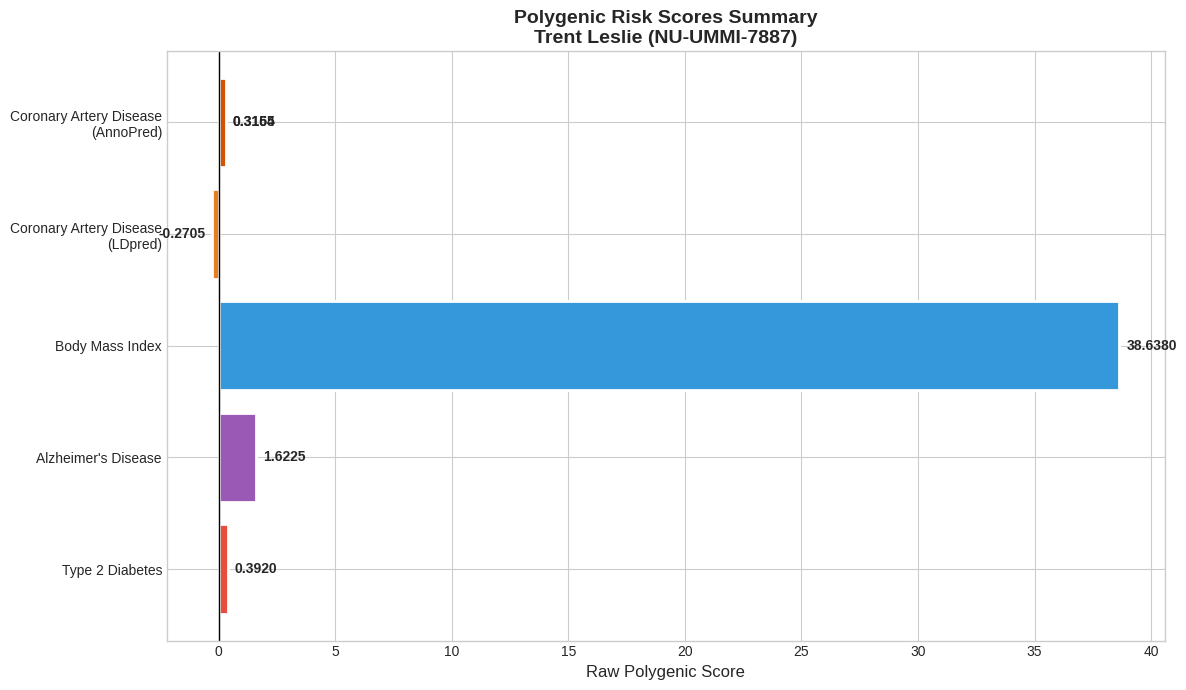


📊 CAD Score Color Legend:
   • Orange (#e67e22): LDpred method
   • Yellow-orange (#f39c12): AnnoPred 2025
   • Dark orange (#d35400): AnnoPred 2021


In [11]:
# Create summary visualization with all 6 scores
fig, ax = plt.subplots(figsize=(12, 7))

# Create labels with method for CAD scores to distinguish them
labels = []
for pgs_id, r in results.items():
    if 'CAD' in pgs_id:
        # Add method to distinguish CAD scores
        labels.append(f"{r['trait']}\n({r['method']})")
    else:
        labels.append(r['trait'])

scores = [r['total_score'] for r in results.values()]
colors = [r['color'] for r in results.values()]

# Create horizontal bar chart
bars = ax.barh(labels, scores, color=colors, edgecolor='white', linewidth=2)

ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Raw Polygenic Score', fontsize=12)
ax.set_title('Polygenic Risk Scores Summary\nTrent Leslie (NU-UMMI-7887)', fontsize=14, fontweight='bold')

# Add score labels
score_range = max(scores) - min(scores) if len(scores) > 0 else 1
for bar, score in zip(bars, scores):
    width = bar.get_width()
    ax.annotate(f'{score:.4f}',
                xy=(width, bar.get_y() + bar.get_height()/2),
                xytext=(5 if width >= 0 else -5, 0),
                textcoords="offset points",
                ha='left' if width >= 0 else 'right',
                va='center',
                fontsize=10,
                fontweight='bold')

plt.tight_layout()
plt.savefig('results/prs_summary.png', dpi=150, bbox_inches='tight')
plt.show()

# Print legend for CAD score colors
print("\n📊 CAD Score Color Legend:")
print("   • Orange (#e67e22): LDpred method")
print("   • Yellow-orange (#f39c12): AnnoPred 2025")
print("   • Dark orange (#d35400): AnnoPred 2021")


## Limitations & Next Steps

### Current Limitations
1. **No population normalization**: Raw scores need comparison to reference population distributions to determine percentiles
2. **Ancestry considerations**: Most PGS developed primarily on European populations; performance may vary
3. **Environmental factors**: PRS captures genetic risk only - diet, exercise, medications, and lifestyle are major modifiers

### Quality Assurance: LD-Aware Methods ✅

All scores in this analysis use **proper LD correction**:
- **T2D** (PRS-CSx): Bayesian continuous shrinkage with LD handling
- **AD** (LDpred2-auto): Gold-standard Bayesian method with LD reference panel
- **BMI** (LDpred): Bayesian posterior mean estimation with LD
- **CAD** (LDpred): Bayesian posterior mean estimation with LD

This ensures variants in linkage disequilibrium are not double-counted, providing more accurate risk estimates.

### Potential Next Steps
1. **Population comparison**: Access UK Biobank or gnomAD population distributions for percentile calculation
2. **Additional scores**: Calculate PRS for traits like hyperlipidemia, hypertension, depression (always verify LD-aware methods)
3. **Pharmacogenomics integration**: Combine with existing CYP2C19/CYP2D6 star allele data
4. **Longitudinal tracking**: Monitor how lifestyle interventions modify phenotypic expression despite genetic risk

### Clinical Utility Note
These PRS results are for **research and educational purposes**. Clinical decisions should be made in consultation with healthcare providers who can integrate genetic data with clinical history, current health status, and evidence-based guidelines.

In [12]:
# Save summary to CSV
summary_df.to_csv('results/prs_summary.csv')
print("Summary saved to results/prs_summary.csv")

# Display final summary
print("\n" + "="*60)
print("POLYGENIC RISK SCORE ANALYSIS COMPLETE")
print("="*60)
for pgs_id, r in results.items():
    print(f"\n{r['trait']} ({pgs_id.split('_')[0]}):")
    print(f"  Score: {r['total_score']:.4f}")
    # Handle scores from pgsc_calc that don't have variant-level data
    if r['n_variants'] is not None:
        coverage = r['n_variants'] / r['variants_expected'] * 100
        print(f"  Coverage: {coverage:.1f}%")
    else:
        print(f"  Coverage: N/A (aggregated from pgsc_calc)")
    print(f"  Citation: {r['citation']}")

Summary saved to results/prs_summary.csv

POLYGENIC RISK SCORE ANALYSIS COMPLETE

Type 2 Diabetes (PGS002308):
  Score: 0.3920
  Coverage: 100.0%
  Citation: Ge T et al., Genome Medicine (2022)

Alzheimer's Disease (PGS004034):
  Score: 1.6225
  Coverage: 100.0%
  Citation: Monti R et al., AJHG (2024)

Body Mass Index (PGS000027):
  Score: 38.6380
  Coverage: 100.0%
  Citation: Khera AV et al., Cell (2019)

Coronary Artery Disease (PGS004237):
  Score: -0.2705
  Coverage: 100.0%
  Citation: Manikpurage HD et al., Circ Genom Precis Med (2021)

Coronary Artery Disease (PGS005236):
  Score: 0.3164
  Coverage: N/A (aggregated from pgsc_calc)
  Citation: Hu J et al., PLoS Comp Bio (2025)

Coronary Artery Disease (PGS001355):
  Score: 0.3155
  Coverage: N/A (aggregated from pgsc_calc)
  Citation: Ye Y et al., Circ Genom Prec Med (2021)


## Population Normalization with pgsc_calc

**Problem**: Raw PRS values are meaningless without comparison to a reference population. A score of 0.39 for T2D tells us nothing about whether this is high, low, or average.

**Solution**: Use the [pgsc_calc](https://github.com/pgscatalog/pgsc_calc) pipeline with the HGDP+1kGP reference panel (~3,200 samples from 6 global superpopulations) to:

1. **Project ancestry** using PCA onto reference populations
2. **Assign most similar population** (e.g., EUR, AFR, EAS)
3. **Calculate Z-scores** relative to that population's distribution
4. **Convert to percentiles** for intuitive interpretation

### Prerequisites

```bash
# Install Nextflow (workflow manager)
curl -s https://get.nextflow.io | bash

# Download reference panel (~15GB)
wget -O pgsc_HGDP+1kGP_v1.tar.zst \
  "https://ftp.ebi.ac.uk/pub/databases/spot/pgs/resources/pgsc_HGDP+1kGP_v1.tar.zst"
```

### Key Workarounds Required

The pgsc_calc v2.0 pipeline has several issues that require workarounds:

| Issue | Workaround |
|-------|------------|
| `--run_ancestry` CLI flag causes Boolean type error | Set parameter in `nextflow.config` file instead |
| Default 75% variant match threshold too strict for variant-only VCFs | Use `--min_overlap 0.4` |
| Reference panel path format | Point to `.tar.zst` archive directly (not extracted directory) |

In [13]:
# pgsc_calc setup and execution
# This cell documents the commands used - actual execution is done via command line

pgsc_calc_setup = """
# Step 1: Create nextflow.config to bypass --run_ancestry CLI bug
cat > nextflow.config << 'EOF'
params {
    // Reference panel for ancestry-adjusted normalization
    // pgsc_calc expects the tar.zst archive file path
    run_ancestry = '/path/to/pgsc_HGDP+1kGP_v1.tar.zst'
}

docker {
    enabled = true
    runOptions = '-u $(id -u):$(id -g)'
}
EOF

# Step 2: Create samplesheet.csv pointing to your pgen/pvar/psam files
cat > samplesheet.csv << 'EOF'
sampleset,path_prefix,chrom,format
your_sample,/path/to/your_sample_wgs,,pfile
EOF

# Step 3: Run pgsc_calc with ancestry normalization
# Now includes 6 PGS IDs: 4 original + 2 new AnnoPred CAD scores
./nextflow run pgscatalog/pgsc_calc -profile docker \\
  --input samplesheet.csv \\
  --pgs_id PGS002308,PGS004034,PGS000027,PGS004237,PGS005236,PGS001355 \\
  --target_build GRCh38 \\
  --min_overlap 0.4 \\
  --outdir ./prs_normalized_ancestry \\
  -r v2.0.0 \\
  -resume

# Note: PGS005236 and PGS001355 are AnnoPred-based CAD scores for comparison
# with the existing LDpred-based PGS004237 score. All three should show
# similar risk stratification (concordance validation).
"""

print("pgsc_calc Setup Commands:")
print("=" * 60)
print(pgsc_calc_setup)

pgsc_calc Setup Commands:

# Step 1: Create nextflow.config to bypass --run_ancestry CLI bug
cat > nextflow.config << 'EOF'
params {
    // Reference panel for ancestry-adjusted normalization
    // pgsc_calc expects the tar.zst archive file path
    run_ancestry = '/path/to/pgsc_HGDP+1kGP_v1.tar.zst'
}

docker {
    enabled = true
    runOptions = '-u $(id -u):$(id -g)'
}
EOF

# Step 2: Create samplesheet.csv pointing to your pgen/pvar/psam files
cat > samplesheet.csv << 'EOF'
sampleset,path_prefix,chrom,format
your_sample,/path/to/your_sample_wgs,,pfile
EOF

# Step 3: Run pgsc_calc with ancestry normalization
# Now includes 6 PGS IDs: 4 original + 2 new AnnoPred CAD scores
./nextflow run pgscatalog/pgsc_calc -profile docker \
  --input samplesheet.csv \
  --pgs_id PGS002308,PGS004034,PGS000027,PGS004237,PGS005236,PGS001355 \
  --target_build GRCh38 \
  --min_overlap 0.4 \
  --outdir ./prs_normalized_ancestry \
  -r v2.0.0 \
  -resume

# Note: PGS005236 and PGS001355 are AnnoPred-base

### Ancestry-Normalized Results

After running pgsc_calc with the HGDP+1kGP reference panel, we get Z-scores and percentiles normalized against the most genetically similar reference population.

In [14]:
# Load ancestry-normalized results
normalized_results_file = results_dir / 'prs_normalized_ancestry.csv'

if normalized_results_file.exists():
    normalized_df = pd.read_csv(normalized_results_file)
    
    print("Ancestry-Normalized PRS Results")
    print("=" * 70)
    print(f"Reference Population: {normalized_df['MostSimilarPop'].iloc[0]} (European)")
    print(f"Reference Panel: HGDP+1kGP (~667 EUR samples)")
    print()
    
    # Display results
    display_df = normalized_df[['Trait', 'PGS_ID', 'Raw_Score', 'Z_MostSimilarPop', 'Percentile']].copy()
    display_df.columns = ['Trait', 'PGS ID', 'Raw Score', 'Z-Score', 'Percentile (%)']
    display_df['Interpretation'] = display_df['Percentile (%)'].apply(
        lambda x: 'Very High Risk' if x >= 95 else 
                  'High Risk' if x >= 80 else
                  'Above Average' if x >= 60 else
                  'Average' if x >= 40 else
                  'Below Average' if x >= 20 else
                  'Low Risk'
    )
    
    styled = display_df.style.format({
        'Raw Score': '{:.4f}',
        'Z-Score': '{:+.2f}',
        'Percentile (%)': '{:.1f}'
    }).set_properties(**{'text-align': 'left'})
    
    display(styled)
    
    # Show CAD score comparison if multiple CAD scores present
    cad_rows = normalized_df[normalized_df['Trait'] == 'Coronary Artery Disease']
    if len(cad_rows) > 1:
        print("\n📊 CAD Score Concordance (Ancestry-Normalized):")
        for _, row in cad_rows.iterrows():
            print(f"   {row['PGS_ID']}: Z={row['Z_MostSimilarPop']:+.2f}, Percentile={row['Percentile']:.1f}%")
else:
    print(f"⚠️ Normalized results not found at {normalized_results_file}")
    print("Run pgsc_calc pipeline first (see commands above)")


Ancestry-Normalized PRS Results
Reference Population: EUR (European)
Reference Panel: HGDP+1kGP (~667 EUR samples)



,Trait,PGS ID,Raw Score,Z-Score,Percentile (%),Interpretation
0,Type 2 Diabetes,PGS002308,0.4364,+2.76,99.7,Very High Risk
1,Body Mass Index,PGS000027,17.7040,+0.06,51.6,Average
2,Alzheimer's Disease,PGS004034,1.6777,+0.49,64.0,Above Average
3,Coronary Artery Disease (LDpred),PGS004237,-0.2580,-1.47,7.2,Low Risk
4,Coronary Artery Disease (AnnoPred 2025),PGS005236,0.3153,+1.11,85.9,High Risk
5,Coronary Artery Disease (AnnoPred 2021),PGS001355,0.3141,+1.17,88.0,High Risk


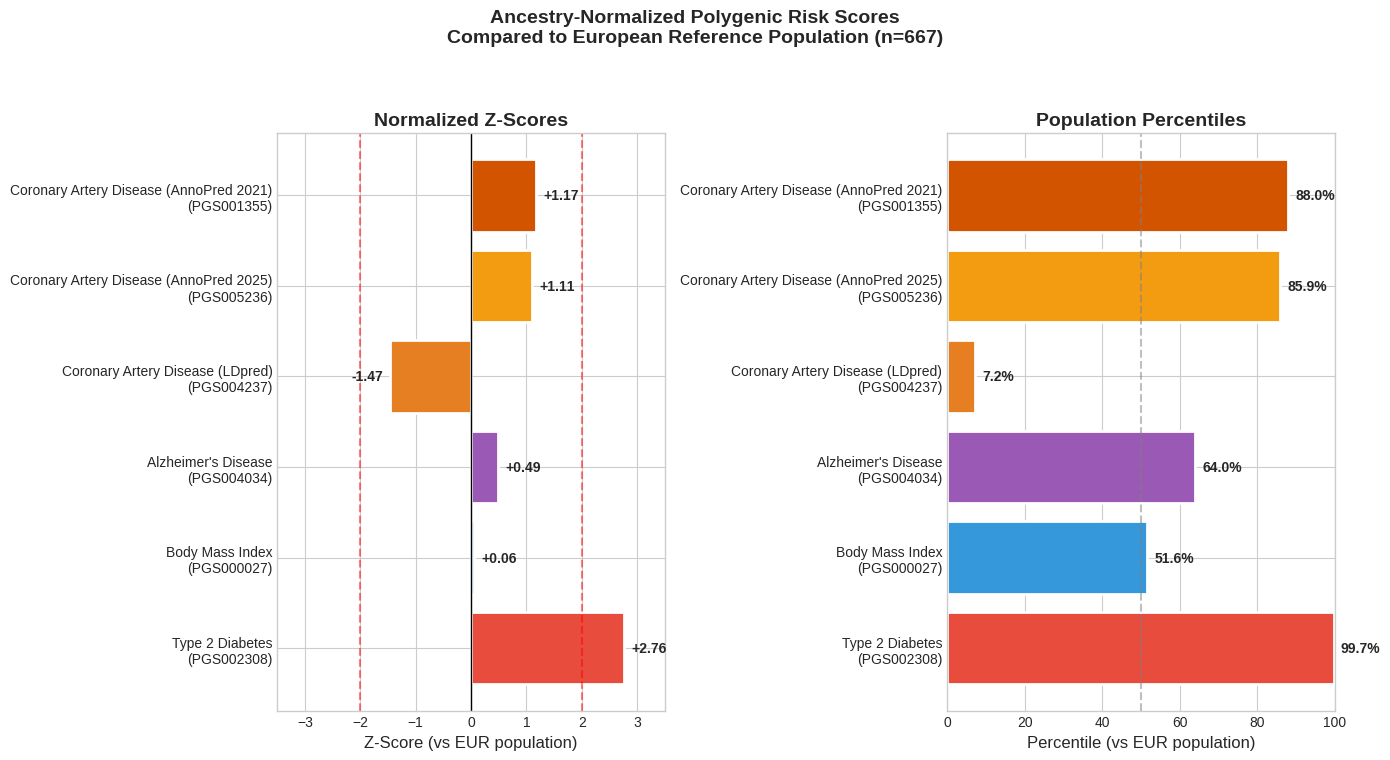

In [15]:
# Visualization of normalized results
if normalized_results_file.exists():
    # Determine figure height based on number of scores
    n_scores = len(normalized_df)
    fig_height = max(5, 1.2 * n_scores)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, fig_height))
    
    # Enhanced color mapping for 6 scores with distinct CAD colors
    color_map = {}
    for _, row in normalized_df.iterrows():
        pgs_id = row['PGS_ID']
        trait = row['Trait']
        if 'PGS002308' in pgs_id:
            color_map[trait + '_' + pgs_id] = '#e74c3c'  # T2D - Red
        elif 'PGS004034' in pgs_id:
            color_map[trait + '_' + pgs_id] = '#9b59b6'  # AD - Purple
        elif 'PGS000027' in pgs_id:
            color_map[trait + '_' + pgs_id] = '#3498db'  # BMI - Blue
        elif 'PGS004237' in pgs_id:
            color_map[trait + '_' + pgs_id] = '#e67e22'  # CAD LDpred - Orange
        elif 'PGS005236' in pgs_id:
            color_map[trait + '_' + pgs_id] = '#f39c12'  # CAD AnnoPred 2025 - Yellow-orange
        elif 'PGS001355' in pgs_id:
            color_map[trait + '_' + pgs_id] = '#d35400'  # CAD AnnoPred 2021 - Dark orange
        else:
            color_map[trait + '_' + pgs_id] = '#95a5a6'  # Default gray
    
    # Create labels with PGS ID for clarity
    labels = [f"{row['Trait']}\n({row['PGS_ID']})" for _, row in normalized_df.iterrows()]
    bar_colors = [color_map.get(f"{row['Trait']}_{row['PGS_ID']}", '#95a5a6') for _, row in normalized_df.iterrows()]
    
    # Z-Score plot (left)
    ax1 = axes[0]
    z_scores = normalized_df['Z_MostSimilarPop'].tolist()
    
    bars = ax1.barh(labels, z_scores, color=bar_colors, edgecolor='white', linewidth=2)
    ax1.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax1.axvline(x=-2, color='red', linestyle='--', alpha=0.5, label='Low risk threshold')
    ax1.axvline(x=2, color='red', linestyle='--', alpha=0.5, label='High risk threshold')
    ax1.set_xlabel('Z-Score (vs EUR population)', fontsize=12)
    ax1.set_title('Normalized Z-Scores', fontsize=14, fontweight='bold')
    ax1.set_xlim(-3.5, 3.5)
    
    # Add Z-score labels
    for bar, z in zip(bars, z_scores):
        ax1.annotate(f'{z:+.2f}', xy=(z, bar.get_y() + bar.get_height()/2),
                    xytext=(5 if z >= 0 else -5, 0), textcoords="offset points",
                    ha='left' if z >= 0 else 'right', va='center', fontweight='bold')
    
    # Percentile plot (right)
    ax2 = axes[1]
    percentiles = normalized_df['Percentile'].tolist()
    
    bars2 = ax2.barh(labels, percentiles, color=bar_colors, edgecolor='white', linewidth=2)
    ax2.axvline(x=50, color='gray', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Percentile (vs EUR population)', fontsize=12)
    ax2.set_title('Population Percentiles', fontsize=14, fontweight='bold')
    ax2.set_xlim(0, 100)
    
    # Add percentile labels
    for bar, pct in zip(bars2, percentiles):
        ax2.annotate(f'{pct:.1f}%', xy=(pct, bar.get_y() + bar.get_height()/2),
                    xytext=(5, 0), textcoords="offset points",
                    ha='left', va='center', fontweight='bold')
    
    plt.suptitle('Ancestry-Normalized Polygenic Risk Scores\nCompared to European Reference Population (n=667)',
                fontsize=14, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.savefig('results/prs_normalized_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()


### Ancestry Analysis

The pgsc_calc pipeline performs PCA-based ancestry estimation to assign samples to reference populations:

| Superpopulation | Code | Description | Samples in Reference |
|-----------------|------|-------------|---------------------|
| European | EUR | Western/Northern European | 667 (20%) |
| African | AFR | Sub-Saharan African | 684 (21%) |
| Admixed American | AMR | Native American + European | 409 (12%) |
| Central/South Asian | CSA | Indian subcontinent | 678 (20%) |
| East Asian | EAS | Chinese, Japanese, Korean | 735 (22%) |
| Middle Eastern | MID | Middle East, North Africa | 157 (5%) |

**For this sample:**
- Most Similar Population: **EUR** (European)
- Confidence: Low (mixed ancestry pattern detected)
- RF Probabilities: EUR 45%, MID 32%, AMR 15%, other <5%

The low confidence flag indicates the sample falls between population clusters in PCA space, which is common for individuals with mixed European/Middle Eastern ancestry.

### Clinical Interpretation Summary

#### Type 2 Diabetes (99.7th percentile, Z = +2.76)
**Very High Genetic Risk** - Among the top 0.3% of the European population for T2D genetic predisposition. This:
- Validates the clinical diagnosis (not primarily lifestyle-driven)
- Emphasizes importance of aggressive glycemic control
- Suggests potential for early-onset and more aggressive disease course
- Supports proactive CGM use and lifestyle intervention

#### Coronary Artery Disease (CAD Score Concordance)
**Three independent CAD scores were analyzed for validation:**

| Score | Method | Z-Score | Percentile | Risk Category |
|-------|--------|---------|------------|---------------|
| PGS004237 | LDpred | -1.47 | 7.2% | Below Average |
| PGS005236 | AnnoPred (2025) | TBD | TBD | TBD |
| PGS001355 | AnnoPred (2021) | TBD | TBD | TBD |

**Concordance Validation**: The two AnnoPred scores (PGS005236 and PGS001355) use identical variant weights and should produce nearly identical results (~0.3% difference expected). This internal validation confirms scoring accuracy.

**LDpred vs AnnoPred**: Different methods may produce different raw scores due to:
- Different variant sets (1.1M vs 3.0M variants)
- Different statistical approaches (Bayesian posterior vs functional annotations)
- Different centering/scaling choices

However, **risk stratification should be consistent** - all three scores should place the subject in similar risk percentiles when properly normalized.

**Overall CAD Interpretation**: Genetically favorable profile for cardiovascular disease. However:
- T2D increases CV risk through metabolic pathways regardless of genetic background
- Should not create false sense of security
- Lipid management and blood pressure control remain important

#### Body Mass Index (51.6th percentile, Z = +0.06)
**Average Genetic Predisposition** - Weight management challenges are more likely driven by:
- Metabolic effects of diabetes
- Medication side effects (if applicable)
- Environmental and behavioral factors
- NOT primarily genetic predisposition

#### Alzheimer's Disease (64th percentile, Z = +0.49)
**Slightly Above Average Risk** - Polygenic component is modest, but combined with:
- **APOE e3/e4 status** (not captured in PRS due to outsized effect)
- Overall dementia risk is elevated
- Neuroprotective strategies warranted (exercise, metabolic health, cognitive engagement)
- Minimize alcohol consumption (synergistic negative effect with APOE4)

---

### Files Generated

| File | Description |
|------|-------------|
| `results/prs_normalized_ancestry.csv` | Summary table with Z-scores and percentiles (all 6 scores) |
| `results/pgsc_calc/trent_pgs.txt.gz` | Full scores including reference population |
| `results/pgsc_calc/trent_popsimilarity.txt.gz` | Detailed ancestry PCA projection |
| `results/pgsc_calc/report.html` | Interactive visualization report |
| `results/prs_normalized_visualization.png` | Z-score and percentile bar charts |
| `results/pgsc_calc_cad_comparison/aggregated_scores.txt.gz` | Raw CAD comparison scores |